<a href="https://colab.research.google.com/github/HuyenNguyenHelen/CORD-19-KG/blob/master/Evaluation/auto_eval_correctness_comprehensiveness_BERT-triples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AUTOMATICALLY LABEL CORRECTNESS AND RELATEDNESS**
## BERT
- **Triples**


In [2]:
#@title Specifying Upsampling Option
UPSAMPLE = True #@param {type:"boolean"}


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 90 kB 1.9 MB/s 
     |████████████████████████████████| 131 kB 65.2 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 8.5 MB 69.0 MB/s 
     |████████████████████████████████| 138 kB 79.5 MB/s 
     |████████████████████████████████| 127 kB 76.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [6]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

# **Loading data**

Connects google drive to this notebook to get the dataset, and then unzip it. Then, we load the specified columns (docID, keyword, country, paragraph and label) into the df.

In [7]:
path = '/content/drive/MyDrive/KG_EVAL_triples/all_triples_sample_1000_all_final.csv'
with open(path, 'r', encoding = 'utf-8') as f:
  data = pd.read_csv(f)
df = data [['subject',	'new_relation',	'object', 'final_eval']]
df.columns = ['subject',	'new_relation',	'object', 'label']
df

,subject,new_relation,object,label
0,syndrome,disease_species,ferret,0
1,disease,disease_disease,flu,1
2,osteopontin,gene_disease,m,0
3,ifn,gene_disease,infection,1
4,degeneration,disease_disease,seizure,1
...,...,...,...,...
995,stat6,gene_gene,gene,1
996,virus,disease_disease,respiratory illness,0
997,mmdb,gene_gene,cn3d,0
998,disease,disease_disease,severe,0


# **Exploring data**



In [8]:
# Observing labels
df['label'].value_counts()

0    580
1    420
Name: label, dtype: int64

In [9]:
#checking for missing values
print('Is null: \n', df.isnull().sum() )

Is null: 
 subject         0
new_relation    0
object          0
label           0
dtype: int64


0    580
1    420
Name: label, dtype: int64


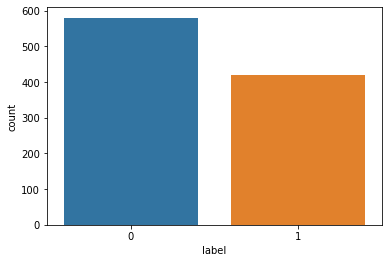

In [10]:

print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# **Data Partition**

Once the data is thoroughly explored, we proceed to partition the shuffled data into training and testing sets with a ratio of 80-20. 

In [11]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df[['subject', 'object']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (800, 2) (800,)
Shapes of X_test, y_test:  (200, 2) (200,)
0    464
1    336
Name: label, dtype: int64


# **Create helper functions for printing and recording performance measures**

This part creates 2 helper function, where printing_eval_scores is responsible for printing out the model performance and get_roc_curve is responsible for extracting different metrics such as false positive rate (FPR), recall, macro-f1 scores and auc score. These 2 functions take the ground truth labels and predicted labels as inputs.

Since the data is very imbalanced, we decide to use macro-F1 score as a standard metric to compare among the candidate models. Macro-F1 score takes both major class and minor class into account regardless of their sizes. Therefore, using this metric will give us a more precise baseline to compare among the models. 

In [12]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'macro', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

# Get the measurements of ROC curve for each model
def get_roc_cuve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)

  # Get testing accuracy:
  acc = accuracy_score( y_test,y_pred)

  # Get testing macro-f1:
  f1 = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)

  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = {'fpr': FPR, 'tpr': recall, 'auc': auc, 'accuracy': acc, 'macro-F1': f1}
  return roc

## **BERT**

In [13]:
# Required packages for BERT is moved to the top, in case restart is required

**Prepare training and testing data for BERT**

In [14]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
# tokenizer.tokenize(X_train[302])

100%|██████████| 231508/231508 [00:00<00:00, 3016379.94B/s]


**Get maximum length of a sentence**

 If it's greater than 512, MAX_LEN is set to be 225. We tried to set it with 512, but we run out of GPU memory, so we decide to set it as 225.

In [15]:
 X_train

,subject,object
988,xenotransplantation,patient
896,ace2,act
716,tracheitis,bronchiolitis
365,plague,sepsis
874,nucleic acid,covid
...,...,...
680,pandemic,demand
612,opacity,ground glass opacity
315,he,diarrhea
551,gene,fipv


In [40]:
# get max len in tokenized train text to set the tokens length in the next step
MAX_LEN = max(map(len, X_train))  # can do len(max(X_train, key=len)) also
print('MAX LEN of trainning sentence is:', MAX_LEN, '\nMAX LEN > 512 is ', MAX_LEN>512)

# Update MAX LEN if it's > 512, set it to be 225 
## 512 is is the maximum seq len of BERT_BASE. But we cannot allow the seq len to be 512 since we'll run out of GPU memory --> Use max len of 225
MAX_LEN = 225 if MAX_LEN > 512 else MAX_LEN

# Convert to tokens using tokenizer
# train_tokens = list(X_train.apply(lambda x:'[CLS]%s[SEP]%s[SEP]' % (tokenizer.tokenize(x['subject']),tokenizer.tokenize(x['object'])),axis=1))
# test_tokens  = list(X_test.apply(lambda x:'[CLS]%s[SEP]%s[SEP]' % (tokenizer.tokenize(x['subject']),tokenizer.tokenize(x['object'])),axis=1))

train_tokens = [i.split(',') for i in (X_train.apply(lambda x: '[CLS],%s,[SEP],%s,[SEP]' % (tokenizer.tokenize(x['subject']),tokenizer.tokenize(x['object'])),axis=1).tolist())]
# test_tokens  = list(X_test.apply(lambda x:'[CLS]%s[SEP]%s[SEP]' % (tokenizer.tokenize(x['subject']),tokenizer.tokenize(x['object']))),axis=1)).tolist()

# print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )

MAX LEN of trainning sentence is: 7 
MAX LEN > 512 is  False


In [41]:
train_tokens

[['[CLS]',
  "['x'",
  " '##eno'",
  " '##tra'",
  " '##ns'",
  " '##pl'",
  " '##anta'",
  " '##tion']",
  '[SEP]',
  "['patient']",
  '[SEP]'],
 ['[CLS]', "['ace'", " '##2']", '[SEP]', "['act']", '[SEP]'],
 ['[CLS]',
  "['tr'",
  " '##ache'",
  " '##itis']",
  '[SEP]',
  "['bro'",
  " '##nch'",
  " '##iol'",
  " '##itis']",
  '[SEP]'],
 ['[CLS]', "['plague']", '[SEP]', "['sep'", " '##sis']", '[SEP]'],
 ['[CLS]',
  "['nuclei'",
  " '##c'",
  " 'acid']",
  '[SEP]',
  "['co'",
  " '##vid']",
  '[SEP]'],
 ['[CLS]', "['detection']", '[SEP]', "['detection']", '[SEP]'],
 ['[CLS]',
  "['em'",
  " '##bol'",
  " '##ization']",
  '[SEP]',
  "['res'",
  " '##ection']",
  '[SEP]'],
 ['[CLS]', "['infection']", '[SEP]', "['infection']", '[SEP]'],
 ['[CLS]', "['infection']", '[SEP]', "['infection']", '[SEP]'],
 ['[CLS]',
  "['scar'",
  " '##ification']",
  '[SEP]',
  "['pun'",
  " '##cta'",
  " '##te'",
  " 'ke'",
  " '##rat'",
  " '##itis']",
  '[SEP]'],
 ['[CLS]', "['cr'", " '##p']", '[SEP]', "['l

In [16]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")
test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)),  maxlen= MAX_LEN, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

KeyError: ignored

In [ ]:
train_tokens_ids

array([[  101,  8902, 14122, ...,     0,     0,     0],
       [  101,  2012,  9488, ...,     0,     0,     0],
       [  101, 15488,  4215, ...,     0,     0,     0],
       ...,
       [  101, 29491,  2581, ...,     0,     0,     0],
       [  101,  8561,  2015, ...,     0,     0,     0],
       [  101, 11498,  6873, ...,     0,     0,     0]])

Upsampling option is available at the top of this notebook. If var UPSAMPLE is checked, the data will be upsampled using SMOTE.

In [ ]:
# Upsampling option
if UPSAMPLE:
  # Upsmapled training data for BERT
  oversampler = SMOTE(random_state=42)
  train_tokens_ids, train_labels = oversampler.fit_resample(train_tokens_ids, y_train)
else:
  train_labels = y_train

train_tokens_ids.shape, train_labels.shape

((1444, 58), (1444,))

In [ ]:
# Mask the paddings with 0 and words with 1
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Initiate BERT Classifier using cuda
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

In [ ]:
EPOCHS = 3
BATCH_SZ = 32

# Train BERT NLP
bert_clf.train_m(train_tokens_ids, train_labels.to_numpy(),train_masks, EPOCHS, BATCH_SZ)

Epoch:  3
45/45.125 loss: 0.14218052545481402 


In [ ]:
train_tokens_ids.shape

(1444, 58)

**Evaluate on Testing Set**

In [ ]:
## Converting test token ids, test labels and test masks to a tensor and the create a tensor dataset out of them.
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1)).float()

# Convert to tensor for maks
test_masks_tensor = torch.tensor(test_masks)


# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Define test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [ ]:
bert_clf.eval()     # Define eval
bert_predicted = [] # To Store predicted result
all_logits = []     # Predicted probabilities that is between 0 to 1 is stored here

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

In [ ]:
rocs = {}
# Get ROC curve measurements
rocs['BERT'] = get_roc_cuve(y_test, bert_predicted)

# Prin performance
print('----------------------------BERT performance---------------------------')
printing_eval_scores(y_test, bert_predicted)

----------------------------BERT performance---------------------------
accuracy score: 0.925
precision score: 0.8548574752763234
recall score: 0.6694444444444445
F1 score: 0.721163676921647

Confusion Matrix:
 [[  7  13]
 [  2 178]]

               precision    recall  f1-score   support

           0       0.78      0.35      0.48        20
           1       0.93      0.99      0.96       180

    accuracy                           0.93       200
   macro avg       0.85      0.67      0.72       200
weighted avg       0.92      0.93      0.91       200



In [ ]:
# Export performance to a txt file

# Set file name according to Upsampling option
if UPSAMPLE == 1: name = 'BERT_SMOTE'
else: name = 'BERT'

txtfile = open( name + '.txt','a+')
txtfile.write(FILE_NAME + '_'+ name +  '=' +  str(rocs['BERT'])+'\n')

txtfile.close()

#**Visualize all models with ROC curves**

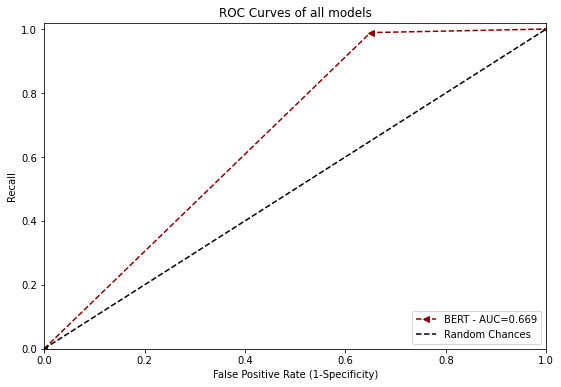

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)